In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator as idg
import os
import shutil
import random
import cv2 as cv
from tqdm.auto import tqdm
from glob import glob
from itertools import permutations
from PIL import Image

# **Mounting Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **U-Net**

In [5]:
images = os.listdir("/content/drive/MyDrive/Machine Learning/Machine Learning/Image")
masks = os.listdir("/content/drive/MyDrive/Machine Learning/Machine Learning/Masks")

In [7]:
v_images = os.listdir("/content/drive/MyDrive/Machine Learning/Machine Learning/val/Img")
v_masks = os.listdir("/content/drive/MyDrive/Machine Learning/Machine Learning/val/msk")

In [8]:
print(len(images)==len(masks))

True


In [9]:
print(len(v_images)==len(v_masks))

True


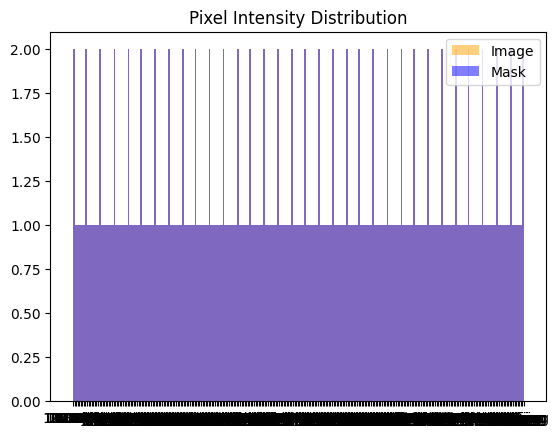

In [10]:
import numpy as np

# Ensure the image and mask are NumPy arrays
image = np.array(images)  # Convert to NumPy array if not already
mask = np.array(masks)    # Convert mask to NumPy array

# Now you can use ravel() to flatten the arrays
plt.hist(image.ravel(), bins=256, color='orange', alpha=0.5, label='Image')
plt.hist(mask.ravel(), bins=256, color='blue', alpha=0.5, label='Mask')
plt.title('Pixel Intensity Distribution')
plt.legend()
plt.show()



In [11]:
masks.sort()
images.sort()

In [12]:
v_masks.sort()
v_images.sort()

In [13]:
import random

i = random.randint(0,len(images)-1)
img = np.asarray(Image.open(os.path.join("/content/drive/MyDrive/Machine Learning/Machine Learning/Image",images[i])))
mask = np.asarray(Image.open(os.path.join("/content/drive/MyDrive/Machine Learning/Machine Learning/Masks",masks[i])))
print(img.shape,mask.shape)

(600, 900, 3) (600, 900, 3)


In [14]:
masks[:10]

['0.jpg',
 '1.jpg',
 '10.jpg',
 '1000.jpg',
 '1001.jpg',
 '1002.jpg',
 '1003.jpg',
 '1004.jpg',
 '1005.jpg',
 '1006.jpg']

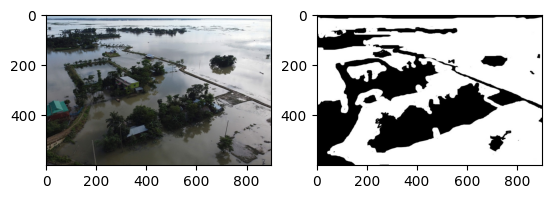

In [15]:
plt.subplot(1,2,1)
plt.imshow(img[:,:,:3]) #rgba to rgb

plt.subplot(1,2,2)
plt.imshow(mask)

plt.show()

#**F1 Score**

In [16]:
def f1_score(y_true, y_pred):
  """
  Calculates the F1-score (harmonic mean of precision and recall) for binary classification.

  Args:
      y_true: Ground truth labels (binary mask).
      y_pred: Predicted labels (binary mask).

  Returns:
      F1-score as a float.
  """
  y_true = y_true.flatten()
  y_pred = y_pred.flatten()

  intersection = np.sum(y_true * y_pred)
  if (np.sum(y_true) == 0 or np.sum(y_pred) == 0):
    return 0  # Avoid division by zero
  precision = intersection / np.sum(y_pred)
  recall = intersection / np.sum(y_true)
  f1 = 2 * (precision * recall) / (precision + recall)

  return f1

# **dice coefficient**

In [17]:
def dice_coefficient(y_true, y_pred):

  smooth = 1.0

  intersection = np.sum(y_true * y_pred)
  union = np.sum(y_true) + np.sum(y_pred) - intersection

  return (2.0 * intersection + smooth) / (union + smooth)

# **IOU**

In [18]:
def IoU(y_true, y_pred):

  intersection = np.sum(y_true * y_pred)
  union = np.sum(y_true) + np.sum(y_pred) - intersection

  # Avoid division by zero
  iou = np.mean((intersection + 1e-5) / (union + 1e-5))
  return iou


In [19]:
def plot_iou_curve(predicted_masks, validation_data):

  validation_images, validation_masks = validation_data

  iou_scores = []

  for threshold in np.arange(0.1, 2.0, 0.1):

    predicted_masks_binary = np.where(predicted_masks > threshold, 1, 0)


    iou_score = IoU(validation_masks.flatten(), predicted_masks_binary.flatten())
    iou_scores.append(iou_score)

  # Plot the IoU curve (threshold vs. IoU score)
  plt.plot(np.arange(0.1, 2.0, 0.1), iou_scores)
  plt.xlabel('Threshold')
  plt.ylabel('IoU Score')
  plt.title('IoU Curve for U-Net Model')
  plt.grid(True)
  plt.show()


## **Make U-Net**

In [20]:
def double_conv_block(prev_layer, filter_count):
   new_layer = Conv2D(filter_count, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(prev_layer)
   new_layer = Conv2D(filter_count, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(new_layer)
   return new_layer

In [21]:
def downsample_block(prev_layer, filter_count):
   skip_features = double_conv_block(prev_layer, filter_count)
   down_sampled = MaxPooling2D(2)(skip_features)
   down_sampled = Dropout(0.3)(down_sampled)
   return skip_features, down_sampled

In [22]:
def upsample_block(prev_layer, skipped_features, n_filters):
   upsampled = Conv2DTranspose(n_filters, 3, 2, padding="same")(prev_layer)
   upsampled = Concatenate()([upsampled, skipped_features])
   upsampled = Dropout(0.3)(upsampled)
   upsampled = double_conv_block(upsampled, n_filters)
   return upsampled

In [23]:
def make_unet():
    inputs = Input(shape=(128, 128, 1))

    # Encoder (Downsampling Path)
    skipped_fmaps_1, downsample_1 = downsample_block(inputs, 64)
    skipped_fmaps_2, downsample_2 = downsample_block(downsample_1, 128)
    skipped_fmaps_3, downsample_3 = downsample_block(downsample_2, 256)
    skipped_fmaps_4, downsample_4 = downsample_block(downsample_3, 512)
    skipped_fmaps_5, downsample_5 = downsample_block(downsample_4, 1024)  # Extra downsample block
    skipped_fmaps_6, downsample_6 = downsample_block(downsample_5, 2048)  # Another downsample block

    # Bottleneck
    bottleneck = double_conv_block(downsample_6, 4096)

    # Decoder (Upsampling Path)
    upsample_1 = upsample_block(bottleneck, skipped_fmaps_6, 2048)
    upsample_2 = upsample_block(upsample_1, skipped_fmaps_5, 1024)
    upsample_3 = upsample_block(upsample_2, skipped_fmaps_4, 512)
    upsample_4 = upsample_block(upsample_3, skipped_fmaps_3, 256)
    upsample_5 = upsample_block(upsample_4, skipped_fmaps_2, 128)
    upsample_6 = upsample_block(upsample_5, skipped_fmaps_1, 64)

    # Output Layer
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(upsample_6)

    # Create Model
    unet_model = Model(inputs, outputs, name="U-Net")

    return unet_model

In [24]:
from keras.layers import Conv2D,Conv2DTranspose,MaxPooling2D,Dropout,Concatenate,Input
from keras import Model

In [25]:
u_net = make_unet()

In [26]:
u_net.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 128)    │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 16, 16, 256)    │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 8, 8, 512)      │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 553,578,817 (2.06 GB)

 Trainable params: 553,578,817 (2.06 GB)

 Non-trainable params: 0 (0.00 B)

In [27]:
def make_dataset(validation=False):
  x = []
  y = []
  if(validation):
    for i,(image,mask) in enumerate(zip(v_images[:1500],v_masks[:1500])):
      print("\r"+str(i+1)+"/"+str(len(v_images)),end="")

      image = Image.open(os.path.join("/content/drive/MyDrive/Machine Learning/Machine Learning/val/Img",image)).convert('L')
      mask = Image.open(os.path.join("/content/drive/MyDrive/Machine Learning/Machine Learning/val/msk",mask)).convert('L')

      image = np.asarray(image.resize((128,128)))/255.
      mask = np.asarray(mask.resize((128,128)))/255.

      x.append(image)
      y.append(mask)
  else:
    for i,(image,mask) in enumerate(zip(images[:3500],masks[:3500])):
      print("\r"+str(i+1)+"/"+str(len(images)),end="")

      image = Image.open(os.path.join("/content/drive/MyDrive/Machine Learning/Machine Learning/Image",image)).convert('L')
      mask = Image.open(os.path.join("/content/drive/MyDrive/Machine Learning/Machine Learning/Masks",mask)).convert('L')

      image = np.asarray(image.resize((128,128)))/255.
      mask = np.asarray(mask.resize((128,128)))/255.

      x.append(image)
      y.append(mask)

  return np.array(x),np.array(y)

In [28]:
x,y = make_dataset()

290/290

In [29]:
v_x,v_y = make_dataset(True)

14/14

In [30]:
def get_colored_mask(mask):
    colormap = plt.get_cmap('viridis')
    colored_mask = colormap(mask.squeeze())
    return colored_mask

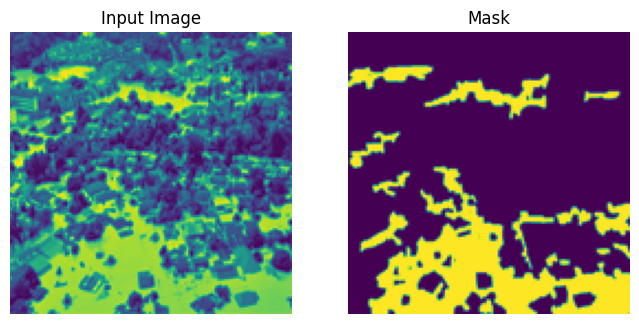

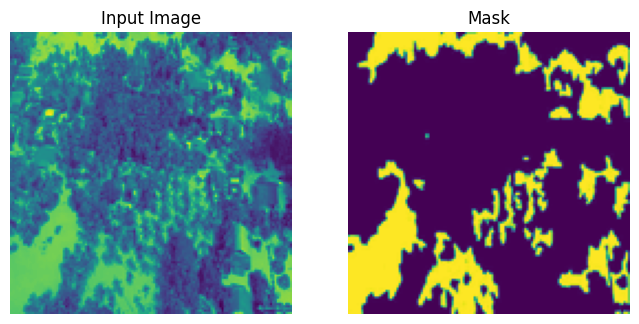

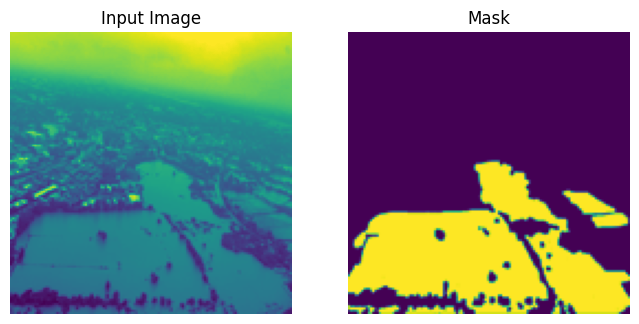

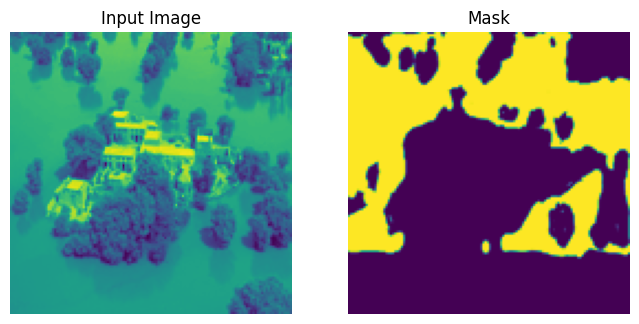

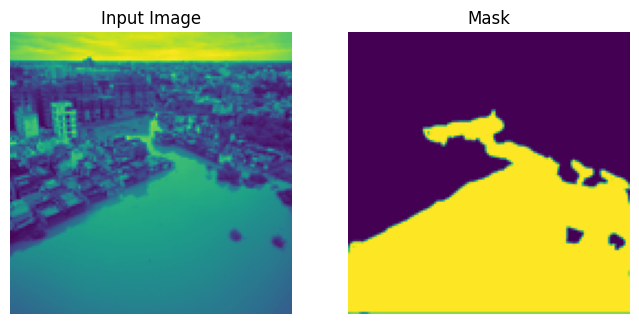

In [31]:
for i in range(5):
    plt.figure(figsize=(8, 6))

    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(x[i])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Mask')
    colored_mask = get_colored_mask(y[i])
    plt.imshow(colored_mask)
    plt.axis('off')

    plt.show()

# **Eda before taining**

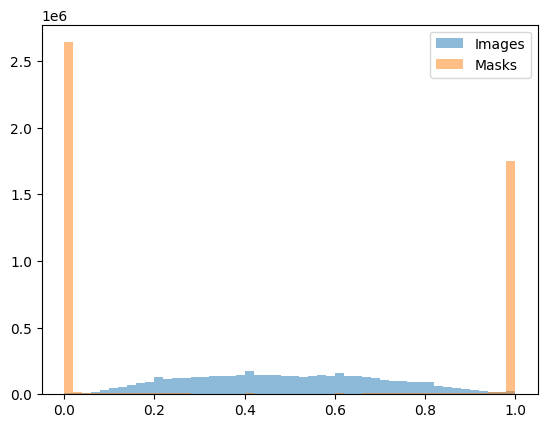

In [32]:
import matplotlib.pyplot as plt
plt.hist(x.flatten(), bins=50, alpha=0.5, label='Images')
plt.hist(y.flatten(), bins=50, alpha=0.5, label='Masks')
plt.legend()
plt.show()


In [33]:
background_ratio = np.mean(y == 0)
foreground_ratio = np.mean(y > 0)
print(f"Background ratio: {background_ratio}, Foreground ratio: {foreground_ratio}")


Background ratio: 0.5448435816271552, Foreground ratio: 0.4551564183728448


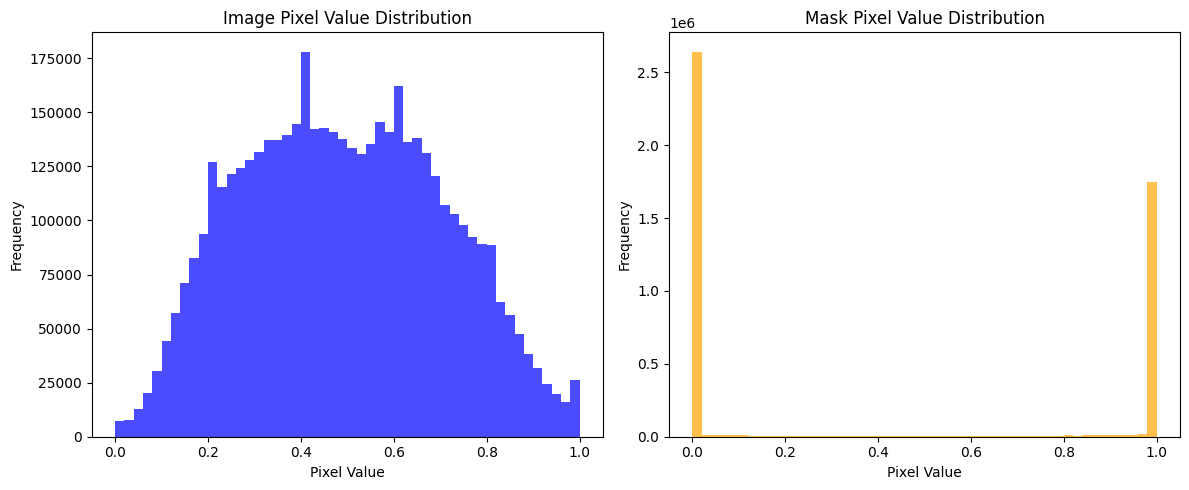

In [34]:
#Check Data Distribution:

def plot_pixel_distribution(images, masks):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title('Image Pixel Value Distribution')
    plt.hist(images.flatten(), bins=50, alpha=0.7, color='blue')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.title('Mask Pixel Value Distribution')
    plt.hist(masks.flatten(), bins=50, alpha=0.7, color='orange')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_pixel_distribution(x, y)




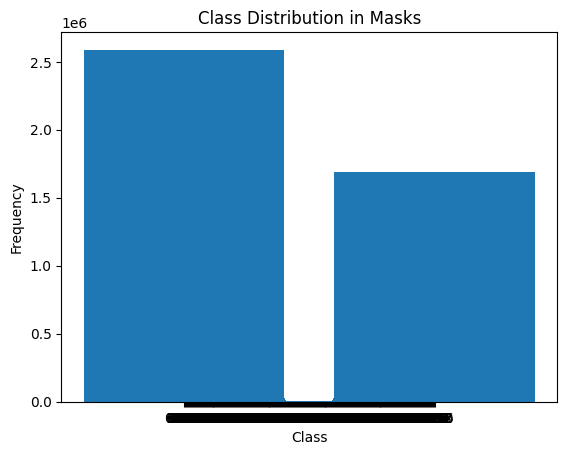

In [35]:
#Check for Class Imbalance:

def class_distribution(masks):
    unique, counts = np.unique(masks, return_counts=True)
    plt.bar(unique, counts)
    plt.title('Class Distribution in Masks')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(unique)
    plt.show()

class_distribution(y)


In [36]:
#Check for Corruption or Missing Data:

def check_for_corruption(images, masks):
    for i in range(len(images)):
        if images[i] is None or masks[i] is None:
            print(f'Corrupted data found at index {i}')

check_for_corruption(x, y)


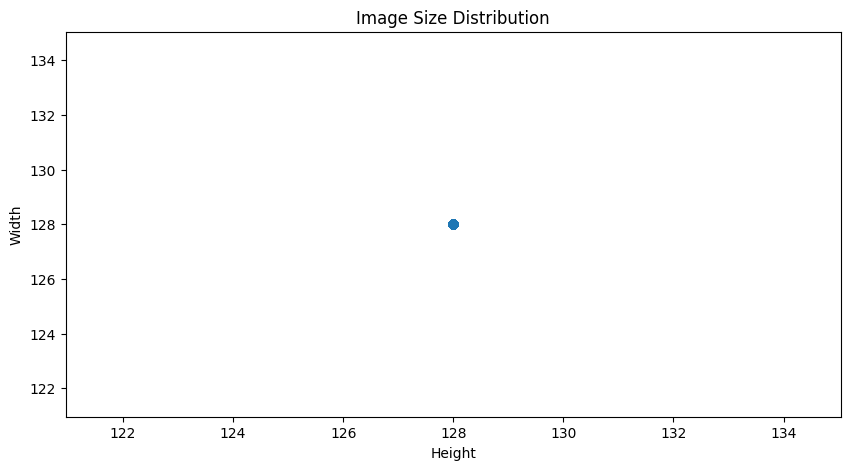

In [37]:
#Visualize Image Size Distribution:
image_sizes = [img.shape for img in x]
height, width = zip(*image_sizes)

plt.figure(figsize=(10, 5))
plt.scatter(height, width, alpha=0.5)
plt.title('Image Size Distribution')
plt.xlabel('Height')
plt.ylabel('Width')
plt.show()


**NP save**

In [38]:
np.save('/content/drive/MyDrive/Machine Learning/Machine Learning/Processed Data/x_train.npy', x)
np.save('/content/drive/MyDrive/Machine Learning/Machine Learning/Processed Data/y_train.npy', y)

# Save the validation dataset
np.save('/content/drive/MyDrive/Machine Learning/Machine Learning/Processed Data/x_val.npy', v_x)
np.save('/content/drive/MyDrive/Machine Learning/Machine Learning/Processed Data/y_val.npy', v_y)

In [39]:
x = np.load('/content/drive/MyDrive/Machine Learning/Machine Learning/Processed Data/x_train.npy')
y = np.load('/content/drive/MyDrive/Machine Learning/Machine Learning/Processed Data/y_train.npy')

# Load the validation dataset
v_x = np.load('/content/drive/MyDrive/Machine Learning/Machine Learning/Processed Data/x_val.npy')
v_y = np.load('/content/drive/MyDrive/Machine Learning/Machine Learning/Processed Data/y_val.npy')

In [40]:
x,y = np.expand_dims(x,axis=-1),np.expand_dims(y,axis=-1)
v_x,v_y = np.expand_dims(v_x,axis=-1),np.expand_dims(v_y,axis=-1)

# **Data Augmentation**

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=[.7, 1.6],
    fill_mode="reflect",
    horizontal_flip=True,
    vertical_flip=True,

)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1

image_generator = image_datagen.flow(
    x,
    batch_size=16,
    seed=seed)

mask_generator = mask_datagen.flow(
    y,
    batch_size=16,
    seed=seed)
train_generator = zip(image_generator, mask_generator)

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_test_datagen = ImageDataGenerator()
mask_test_datagen = ImageDataGenerator()

seed = 4

image_test_generator = image_test_datagen.flow(
    v_x,
    batch_size=20,
    seed=seed)

mask_test_generator = mask_test_datagen.flow(
    v_y,
    batch_size=20,
    seed=seed)

valid_generator = zip(image_test_generator, mask_test_generator)

In [43]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [44]:
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [45]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

In [46]:
from tensorflow.keras.optimizers import Adamax

u_net.compile(
    optimizer=Adamax(learning_rate=0.0001),  # Correct way to set learning rate
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [47]:
#u_net.compile(optimizer="adam",loss="binary_crossentropy",metrics="accuracy")

In [48]:
def combine_generator(image_gen, mask_gen):
    while True:
        image_batch = next(image_gen)
        mask_batch = next(mask_gen)
        yield (image_batch, mask_batch)



In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation arguments
data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=[0.7, 1.6],
    fill_mode="reflect",
    horizontal_flip=True,
    vertical_flip=True,
)

# Image and mask data generators
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Test data generators (no augmentation, just rescaling if necessary)
image_test_datagen = ImageDataGenerator()
mask_test_datagen = ImageDataGenerator()

seed = 1

# Image and mask generators for training
image_generator = image_datagen.flow(x, batch_size=16, seed=seed)
mask_generator = mask_datagen.flow(y, batch_size=16, seed=seed)

# Image and mask generators for validation
image_test_generator = image_test_datagen.flow(v_x, batch_size=20, seed=seed)
mask_test_generator = mask_test_datagen.flow(v_y, batch_size=20, seed=seed)

# Combine generators
def combine_generator(image_gen, mask_gen):
    while True:
        image_batch = next(image_gen)
        mask_batch = next(mask_gen)
        yield (image_batch, mask_batch)

train_generator = combine_generator(image_generator, mask_generator)
valid_generator = combine_generator(image_test_generator, mask_test_generator)

# Fit the model
model_history = u_net.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    steps_per_epoch=130,
    validation_steps=32,
    callbacks=[early_stopping, tensorboard]
)


Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.5215 - loss: 0.6560 - val_accuracy: 0.5868 - val_loss: 0.6547
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 93s 718ms/step - accuracy: 0.6462 - loss: 0.5424 - val_accuracy: 0.6464 - val_loss: 0.5816
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 89s 685ms/step - accuracy: 0.6616 - loss: 0.5135 - val_accuracy: 0.6547 - val_loss: 0.5938
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 94s 726ms/step - accuracy: 0.6770 - loss: 0.4870 - val_accuracy: 0.6717 - val_loss: 0.5815
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 93s 713ms/step - accuracy: 0.6841 - loss: 0.4782 - val_accuracy: 0.7471 - val_loss: 0.4805
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 93s 714ms/step - accuracy: 0.6917 - loss: 0.4553 - val_accuracy: 0.7725 - val_loss: 0.4180
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 90s 690ms/step - accuracy: 0.7023 - loss: 0.4333 - val_accuracy: 0.7705 - val_loss: 0.4265
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 92s 709ms/step - accuracy: 0.7046 - loss: 0.4

In [50]:
loss, accuracy = u_net.evaluate(v_x, v_y)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.8816 - loss: 0.1740
Test Loss: 0.17400218546390533
Test Accuracy: 0.8816048502922058


In [51]:
train_dice_loss = model_history.history['loss']
val_dice_loss = model_history.history['val_loss']

# **Testing**

In [52]:
predictions = u_net.predict(v_x)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [53]:
# unet_predict1 = (predictions > 0.1).astype(np.float32)
# unet_predict2 = (predictions > 0.2).astype(np.float32)
# unet_predict3 = (predictions > 0.3).astype(np.float32)
# unet_predict4 = (predictions > 0.4).astype(np.float32)

In [ ]:
len(predictions)

14

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


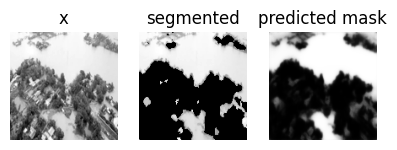

In [54]:
i = random.randint(0,len(v_x)-1)

original = v_x[i].copy()
original_mask = v_y[i].copy()

mask = u_net.predict(np.expand_dims(original,axis=0))


segmented = np.squeeze(original).copy()
segmented[np.squeeze(mask)<0.2] = 0

plt.subplot(1,4,1)
plt.imshow(np.squeeze(original),cmap="gray")
plt.title("x")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(segmented,cmap="gray")
plt.title("segmented")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(np.squeeze(mask[0]),cmap="gray")
plt.title("predicted mask")
plt.axis("off")

# plt.subplot(1,4,4)
# plt.imshow(np.squeeze(original_mask),cmap="gray")
# plt.title("  original mask")
# plt.axis("off")

plt.show()

In [55]:
sample_index = 0
sample_image = v_x[1]
sample_mask = v_y[1]
sample_prediction = predictions[1]

In [56]:
sample_prediction_binary = (sample_prediction > 0.5).astype(np.float32)

In [57]:
print("Sample Image Shape:", sample_image.shape)
print("Sample Mask Shape:", sample_mask.shape)
print("Predicted Mask Shape:", sample_prediction_binary .shape)


Sample Image Shape: (128, 128, 1)
Sample Mask Shape: (128, 128, 1)
Predicted Mask Shape: (128, 128, 1)


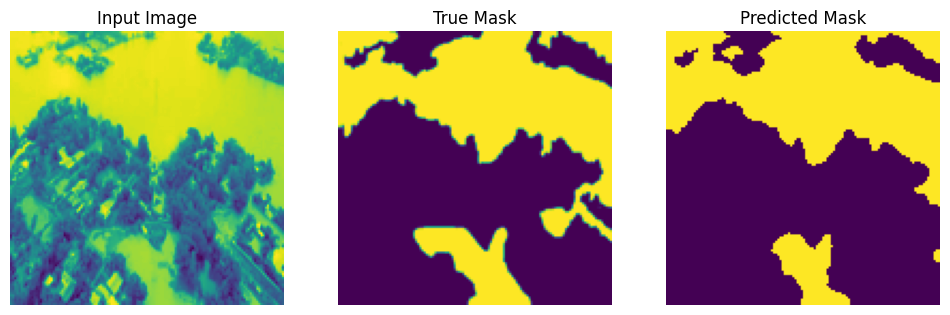

In [58]:
def plot_sample(image, true_mask, pred_mask, index):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    colored_mask = get_colored_mask(true_mask)
    plt.imshow(colored_mask)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    colored_mask = get_colored_mask(pred_mask)
    plt.imshow(colored_mask)
    plt.axis('off')

    plt.show()

# Plot the sample
plot_sample(sample_image, sample_mask, sample_prediction_binary, sample_index)

# **Eda after training**

# **Dice Loss Curve**

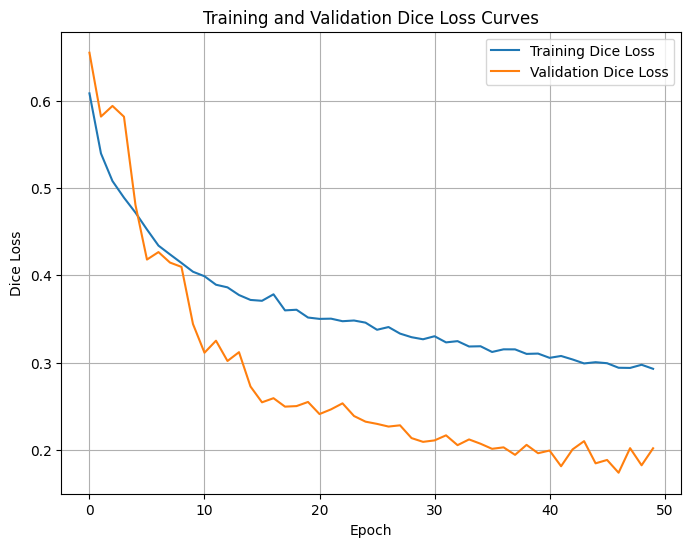

In [59]:

# Create a new figure
plt.figure(figsize=(8, 6))

# Plot training and validation dice loss curves
plt.plot(train_dice_loss, label='Training Dice Loss')
plt.plot(val_dice_loss, label='Validation Dice Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.title('Training and Validation Dice Loss Curves')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# **IOU Score and Curve**

In [60]:
last_val_image, last_val_mask = next(valid_generator)
last_val_pred = u_net.predict(last_val_image)
thresholded_pred = np.squeeze(last_val_pred > 0.5)
iou_score = IoU(np.squeeze(last_val_mask), thresholded_pred)
print(f"IoU score on last validation batch: {iou_score:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
IoU score on last validation batch: 0.8533


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


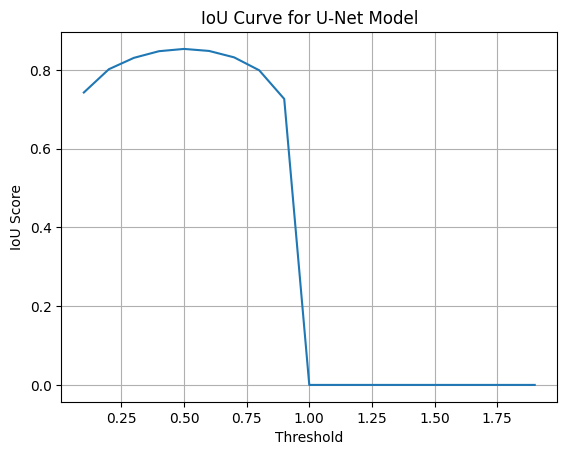

In [61]:
validation_data = next(valid_generator)
predicted_masks = u_net.predict(validation_data[0])
predicted_masks = predicted_masks.flatten()
plot_iou_curve(predicted_masks, validation_data)

In [65]:
from tensorflow.keras import backend as K

In [62]:
validation_images, validation_masks = next(valid_generator)
predicted_masks = u_net.predict(validation_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


# **MSE**

In [66]:
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

mse_loss = mean_squared_error(validation_masks, predicted_masks)
print(f"MSE loss on validation data: {K.eval(mse_loss):.4f}")

MSE loss on validation data: 0.0435


# **F1 Score**

In [67]:
# Calculate F1-score for the last validation batch
last_val_image, last_val_mask = next(valid_generator)
last_val_pred = u_net.predict(last_val_image)
thresholded_pred = np.squeeze(last_val_pred > 0.5)  # Threshold predictions

f1 = f1_score(np.squeeze(last_val_mask), thresholded_pred)
print(f"F1-score on last validation batch: {f1:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
F1-score on last validation batch: 0.9208


# **Dice Co-efficient**

In [68]:
# Calculate Dice coefficient for the last validation batch
last_val_image, last_val_mask = next(valid_generator)
last_val_pred = u_net.predict(last_val_image)

dice_score = dice_coefficient(np.squeeze(last_val_mask), np.squeeze(last_val_pred > 0.5))
print(f"Dice coefficient on last validation batch: {dice_score:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dice coefficient on last validation batch: 1.7066


# **Training and Validation Loss Curve**

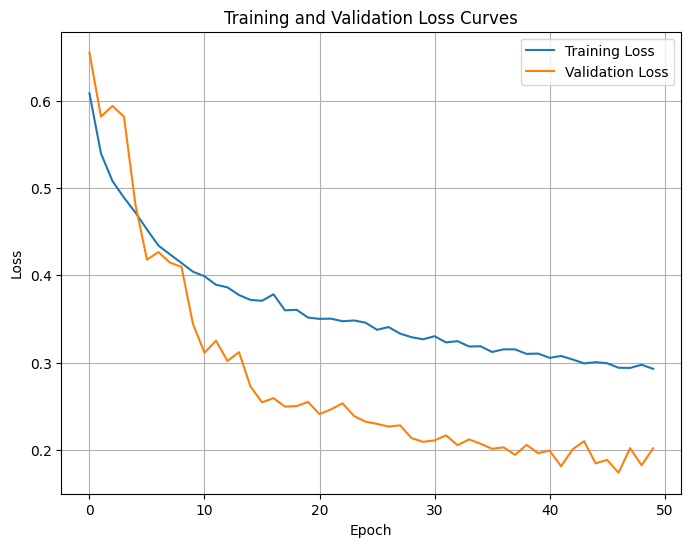

In [69]:
# Extract training and validation loss from model_history
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# Create a new figure
plt.figure(figsize=(8, 6))

# Plot training and validation loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# **Confusion Matrix**

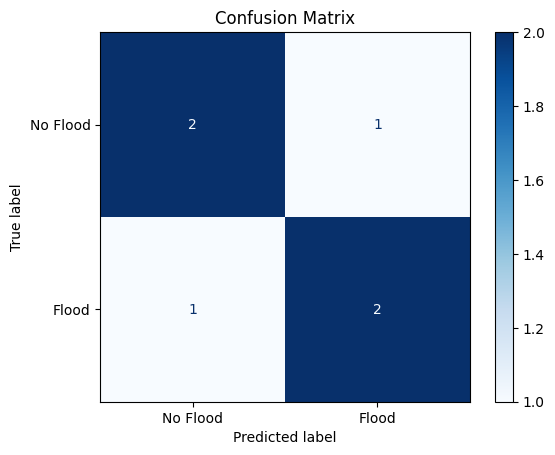

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure inline display in Colab
%matplotlib inline

# Sample true and predicted labels
y_true = np.array([0, 1, 1, 0, 1, 0])  # True labels
y_pred = np.array([0, 0, 1, 0, 1, 1])  # Predicted labels
classes = ['No Flood', 'Flood']  # Class names

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function
plot_confusion_matrix(y_true, y_pred, classes)


# **Classification Report**

In [71]:
import numpy as np
from sklearn.metrics import classification_report

# Sample true and predicted labels
y_true = np.array([0, 1, 1, 0, 1, 0])  # True labels
y_pred = np.array([0, 0, 1, 0, 1, 1])  # Predicted labels

# Class names (make sure these match your data's classes)
target_names = ['No Flood', 'Flood']  # Replace with your actual class names

def print_classification_report(y_true, y_pred, target_names):
    report = classification_report(y_true, y_pred, target_names=target_names)
    print(report)

# Call the function
print_classification_report(y_true, y_pred, target_names)


              precision    recall  f1-score   support

    No Flood       0.67      0.67      0.67         3
       Flood       0.67      0.67      0.67         3

    accuracy                           0.67         6
   macro avg       0.67      0.67      0.67         6
weighted avg       0.67      0.67      0.67         6



# **Pixel Value Distribution of Predictions**

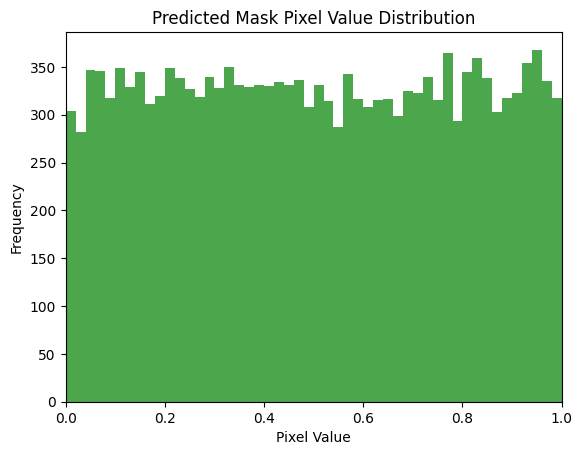

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def plot_prediction_distribution(predictions):
    # Ensure predictions are in the right shape (1D array)
    predictions = predictions.flatten()

    # Plot the histogram
    plt.hist(predictions, bins=50, alpha=0.7, color='green')
    plt.title('Predicted Mask Pixel Value Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.xlim([0, 1])  # Adjust limits based on expected pixel values (0-1 for normalized data)
    plt.show()

# Example usage with mock data
# Replace this with your actual predictions
predictions = np.random.rand(128, 128, 1)  # Example predicted mask with random values
plot_prediction_distribution(predictions)


# **Check for Class Imbalance in Predictions**

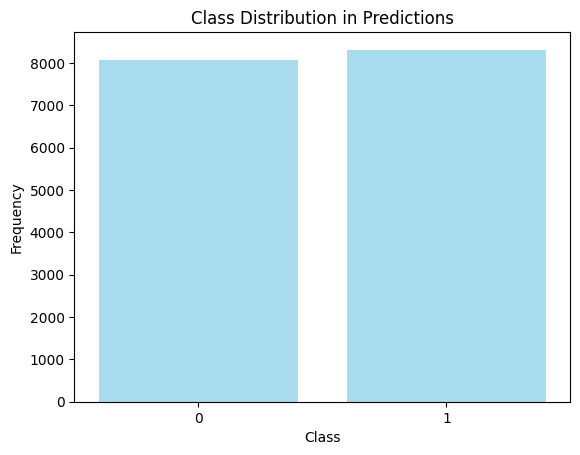

In [73]:
import numpy as np
import matplotlib.pyplot as plt

def plot_predicted_class_distribution(predictions):
    # Ensure predictions are in the correct shape (1D array)
    predictions = predictions.flatten()

    # Get unique classes and their counts
    unique, counts = np.unique(predictions, return_counts=True)

    # Create a bar chart
    plt.bar(unique, counts, color='skyblue', alpha=0.7)
    plt.title('Class Distribution in Predictions')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(unique)  # Set x-ticks to the unique class values
    plt.xlim([min(unique) - 0.5, max(unique) + 0.5])  # Optional: adjust limits for better spacing
    plt.show()

# Example usage with mock data
# Replace this with your actual predictions
predictions = np.random.randint(0, 2, size=(128, 128, 1))  # Example predictions for two classes (0 and 1)
plot_predicted_class_distribution(predictions)
